In [1]:
!pip install matplotlib
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd

data = {
    'step': [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400],
    'training_loss': [0.422800, 0.192400, 0.163200, 0.151700, 0.147200, 0.144400, 0.143500, 0.142200, 0.136000, 0.133900, 0.134500, 0.130500, 0.129300, 0.134100, 0.131600, 0.130600],
    'validation_loss': [0.221644, 0.174804, 0.161552, 0.153756, 0.148764, 0.144602, 0.142639, 0.140508, 0.138366, 0.137547, 0.135980, 0.135701, 0.134428, 0.133708, 0.132987, 0.132426]
}

df = pd.DataFrame(data)
print(df)


    step  training_loss  validation_loss
0     25         0.4228         0.221644
1     50         0.1924         0.174804
2     75         0.1632         0.161552
3    100         0.1517         0.153756
4    125         0.1472         0.148764
5    150         0.1444         0.144602
6    175         0.1435         0.142639
7    200         0.1422         0.140508
8    225         0.1360         0.138366
9    250         0.1339         0.137547
10   275         0.1345         0.135980
11   300         0.1305         0.135701
12   325         0.1293         0.134428
13   350         0.1341         0.133708
14   375         0.1316         0.132987
15   400         0.1306         0.132426


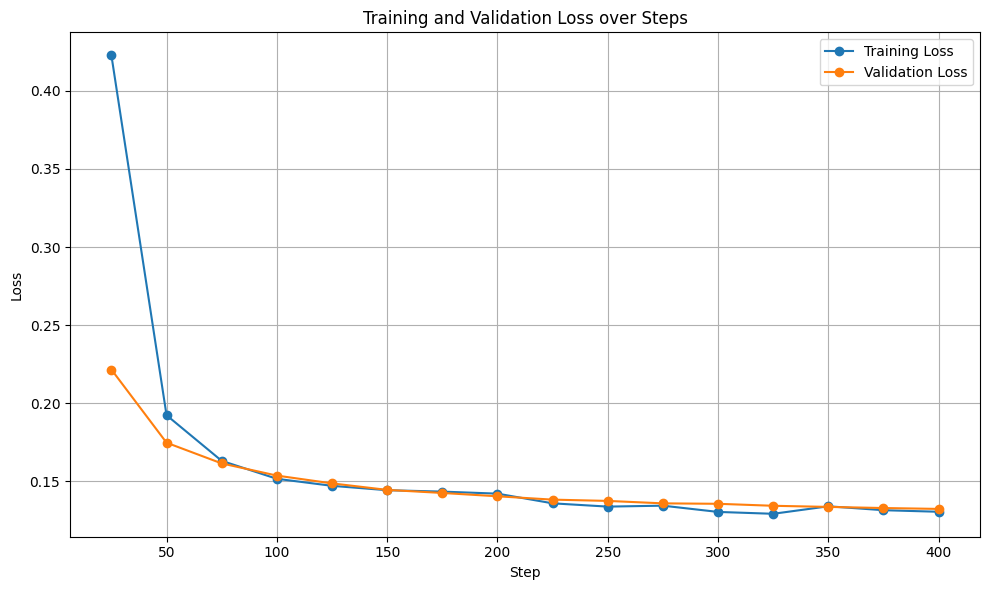

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(df['step'], df['training_loss'], label='Training Loss', marker='o')
plt.plot(df['step'], df['validation_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save or show the plot
#plt.savefig('training_validation_loss_plot.png', dpi=300)
plt.show()

## Qualitative Analysis

In [4]:
from pathlib import Path
import pickle
from swarm_descriptions.mission_elements.arena import CircularArena, RectangularArena
import numpy as np

In [5]:
datasets = []
dataset_path = Path("../ressources/data/eval_checkpoints/")
individual_datasets = list(dataset_path.iterdir())
for dataset in individual_datasets:
    datasets.append(pd.read_pickle(dataset))
    
datasets[0].columns

Index(['description', 'configuration', 'parameters', 'response',
       'argos_config', 'argos_success'],
      dtype='object')

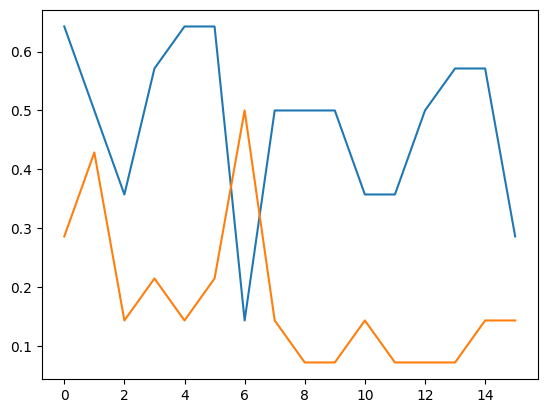

In [6]:
plt.plot([ds.argos_success.sum() / len(ds.argos_success) for ds in datasets])
plt.plot([ds.argos_config.map(lambda x: x is None).sum() / len(ds.argos_success) for ds in datasets])

In [7]:
metrics = pd.read_csv("../ressources/eval_result.csv")
metrics["step"] = metrics.dataset.map(lambda x: int(x.split("-")[1]))
metrics.head()

,bleu_score_mean,bleu_score_var,invalid_config_params,invalid_argos_configs,dataset,step
0,0.863942,0.014835,0.500000,0.142857,checkpoint-25,25
1,0.836989,0.053177,0.142857,0.571429,checkpoint-50,50
2,0.914831,0.022470,0.142857,0.285714,checkpoint-75,75
3,0.904558,0.032057,0.285714,0.642857,checkpoint-100,100
4,0.831330,0.034590,0.428571,0.500000,checkpoint-125,125


### Conversion Results

In [8]:
share_circles = [ds.parameters.map(lambda x: isinstance(x.arena_params, CircularArena)).mean()  for ds in datasets]
share_circles

[0.35714285714285715,
 0.5,
 0.5714285714285714,
 0.42857142857142855,
 0.35714285714285715,
 0.35714285714285715,
 0.5714285714285714,
 0.5714285714285714,
 0.6428571428571429,
 0.42857142857142855,
 0.7857142857142857,
 0.7142857142857143,
 0.35714285714285715,
 0.42857142857142855,
 0.21428571428571427,
 0.35714285714285715]

In [9]:
# invalid argos configs scaled relative to the number of actually valid argos files after conversion (instead of complete dataset). Also the invalid_argos configs label is assigned wrongly. The metrics do represent the share of valid config params
relative_invalid_argos = ((1-metrics["invalid_argos_configs"])*14 - metrics["invalid_config_params"]*14) / (14.0 * 1-(metrics["invalid_config_params"]))

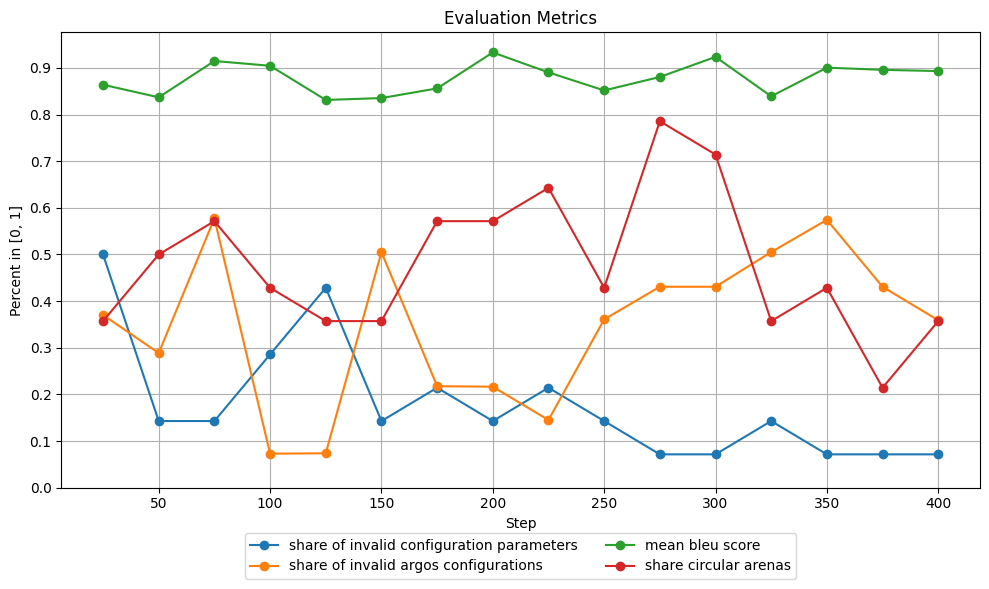

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(metrics['step'], metrics['invalid_config_params'], label='share of invalid configuration parameters', marker='o')
plt.plot(metrics['step'], relative_invalid_argos, label='share of invalid argos configurations', marker='o')
plt.plot(metrics['step'], metrics['bleu_score_mean'], label='mean bleu score', marker='o')
plt.plot(metrics['step'], share_circles, label='share circular arenas', marker='o')
plt.title('Evaluation Metrics')
plt.xlabel('Step')
plt.ylabel('Percent in [0, 1]')
plt.yticks(np.arange(0, 1, step=0.1))
plt.legend(bbox_to_anchor=[0.5, -0.15], 
           loc='center', ncol=2)
plt.grid(True)
plt.tight_layout()

# Save or show the plot
#plt.savefig('training_validation_loss_plot.png', dpi=300)
plt.show()

In [11]:
invalid_circles = [[row if isinstance(row.parameters.arena_params, CircularArena) and row.argos_success == False and row.argos_config is not None else None for index, row in ds.iterrows()] for ds in datasets]
invalid_circles = [row for l in invalid_circles for row in l if row is not None]
len(invalid_circles)

60

In [12]:
valid_circles = [[row if isinstance(row.parameters.arena_params, CircularArena) and row.argos_success == True else None for index, row in ds.iterrows()] for ds in datasets]
distr_valid_circles = [sum([1 for w in l if w is not None]) for l in valid_circles]
print(distr_valid_circles)
valid_circles = [row for l in valid_circles for row in l if row is not None]
len(valid_circles)

[0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 3, 1, 0, 1, 0, 0]


8

In [13]:
invalid_rects = [row for ds in datasets for index, row in ds.iterrows() if isinstance(row.parameters.arena_params, RectangularArena) and row.argos_success == False and row.argos_config is not None]
len(invalid_rects)

17

In [14]:
valid_rects = [row for ds in datasets for index, row in ds.iterrows() if isinstance(row.parameters.arena_params, RectangularArena) and row.argos_success == True and row.argos_config is not None]
len(valid_rects)

99

In [15]:
invalid_config_params = [row for ds in datasets for index, row in ds.iterrows() if row.argos_config is None]
len(invalid_config_params)

40

In [16]:
invalid_argos_configs = [row for ds in datasets for index, row in ds.iterrows() if row.argos_success is False]
len(invalid_argos_configs) - len(invalid_config_params)

77

In [17]:
aggs = [row for row in valid_rects if "agg" in row.description]

In [18]:
rect_index = -4

In [19]:
row = aggs[-4] # rect index
print(row.description)
with open('/tmp/config_params', 'w') as file:
    file.write(row.response)

In this setting, a rectangle is formed with dimensions 4.92 x 5.77 x 2.62.The arena features 1 lights: (-0.73, -1.70, 4.43). Within a 2.36-meter radius from the center, 8 robots are uniformly distributed. In the floor space, you'll discover two distinct areas: a circle at [1.74, -2.00] in white, and another circle at [0.89, 1.43] in black. The primary objective for the robots is to aggregate at the black circle. 


In [35]:
row.configuration

'<?xml version="1.00" ?>\n<config>\n  <swarm-elems>\n    <entity quantity="8" max_trials="100">\n      <e-puck id="epuck">\n        <controller config="automode_bt"/>\n      </e-puck>\n    </entity>\n  </swarm-elems>\n  <env-elems>\n    <light id="light_0" position="-0.73,-1.70,0.00" orientation="360,0,0" color="yellow" intensity="4.43" medium="leds"/>\n    <box id="wall_0" size="0.01,5.77,0.10" movable="false">\n      <body position="0,-2.46,0.00" orientation="90.00,0.00,0.00"/>\n    </box>\n    <box id="wall_1" size="0.01,4.92,0.10" movable="false">\n      <body position="2.88,0,0.00" orientation="0.00,0.00,0.00"/>\n    </box>\n    <box id="wall_2" size="0.01,5.77,0.10" movable="false">\n      <body position="0,2.46,0" orientation="90.00,0.00,0.00"/>\n    </box>\n    <box id="wall_3" size="0.01,4.92,0.10" movable="false">\n      <body position="-2.88,0,0" orientation="0,0.00,0.00"/>\n    </box>\n    <arena-attrib size="5.77,4.92,2.62"/>\n  </env-elems>\n  <objective-elems>\n    <spaw

In [20]:
len([row for ds in datasets for index, row in ds.iterrows()])

224

In [21]:
16*14

224

In [22]:
224-(77+40)

107

In [23]:
metrics.bleu_score_mean

0     0.863942
1     0.836989
2     0.914831
3     0.904558
4     0.831330
5     0.835322
6     0.856065
7     0.933210
8     0.890405
9     0.851681
10    0.880593
11    0.923643
12    0.839112
13    0.900587
14    0.895825
15    0.893274
Name: bleu_score_mean, dtype: float64

In [24]:
metrics.bleu_score_var

0     0.014835
1     0.053177
2     0.022470
3     0.032057
4     0.034590
5     0.029052
6     0.033556
7     0.007292
8     0.021219
9     0.029906
10    0.035674
11    0.008065
12    0.022338
13    0.007555
14    0.028100
15    0.010447
Name: bleu_score_var, dtype: float64

In [25]:
df = datasets[-1]
df[df.argos_config.map(lambda x: x is None)].response.iloc[0]

'<?xml version="1.00" ?>\n<config>\n  <swarm-elems>\n    <entity quantity="15" max_trials="100">\n      <e-puck id="epuck">\n        <controller config="automode_bt"/>\n      </e-puck>\n    </entity>\n  </swarm-elems>\n  <env-elems>\n    <light id="light_0" position="-0.22,0.22,0.00" orientation="360,360,360" color="yellow" intensity="4.71" medium="leds"/>\n    <light id="light_1" position="0.22,0.12,0.00" orientation="360,360,360" color="yellow" intensity="4.81" medium="leds"/>\n    <box id="wall_0" size="0.01,0.32,0.10" movable="false">\n      <body position="1.20,0.16,0" orientation="7.27,0,0"/>\n    </box>\n    <box id="wall_1" size="0.01,0.32,0.10" movable="false">\n      <body position="1.12,0.48,0" orientation="21.86,0,0"/>\n    </box>\n    <box id="wall_2" size="0.01,0.32,0.10" movable="false">\n      <body position="1.00,0.76,0" orientation="36.46,0,0"/>\n    </box>\n    <box id="wall_3" size="0.01,0.32,0.10" movable="false">\n      <body position="0.83,0.99,0" orientation="51

In [26]:
df = datasets[-1]

In [27]:
df.iloc[3].argos_config is None

False

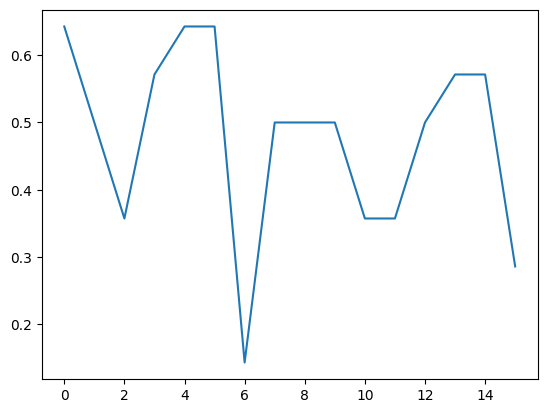

In [28]:
plt.plot([ds.argos_success.sum() / len(ds.argos_success) for ds in datasets])

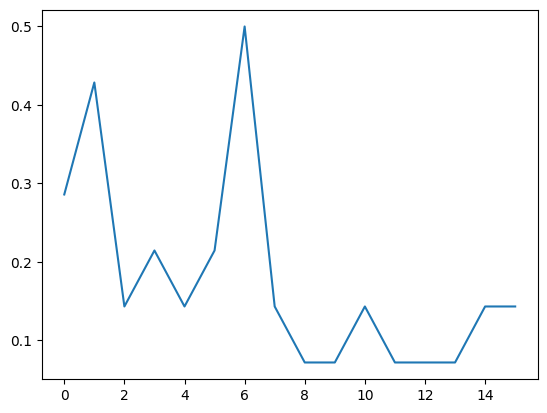

In [29]:
plt.plot([sum([d is None for d in ds.argos_config]) / len(ds.argos_config) for ds in datasets])

Total number of invalid config params for last checkpoint

In [30]:
round(metrics.iloc[-1].invalid_config_params * 14)

1

Total number of missions where argos did not run successfully due to any reason (including above)

In [31]:
(1- metrics.iloc[-1].invalid_argos_configs) * 14

6.0

Share of all runs that are successful in last checkpoint

In [32]:
share_valid_cp_400_total = ((14-6)/14.0)
share_valid_cp_400_total

0.5714285714285714

In [33]:
datasets[-1].argos_config.map(lambda x: x is None).sum() # Should be 1 according to metrics - there might be a mismatch somewhere, so datasets should be used with caution

2

In [34]:
share_circles[-1] + share_valid_cp_400_total # almost all invalids are cicles.

0.9285714285714286